# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


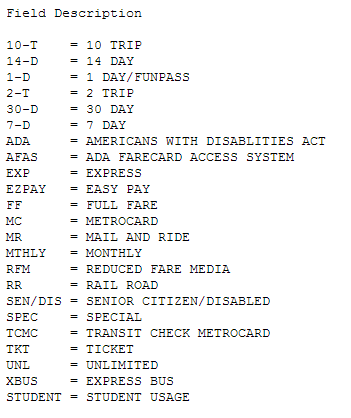

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
mta = np.load("MTA_Fare.npy")

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [4]:
mta = mta.astype(float)
mta[mta==-1]=np.nan

In [5]:
mtaDate = pd.date_range(start='05-21-2010', periods=194, freq='W')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


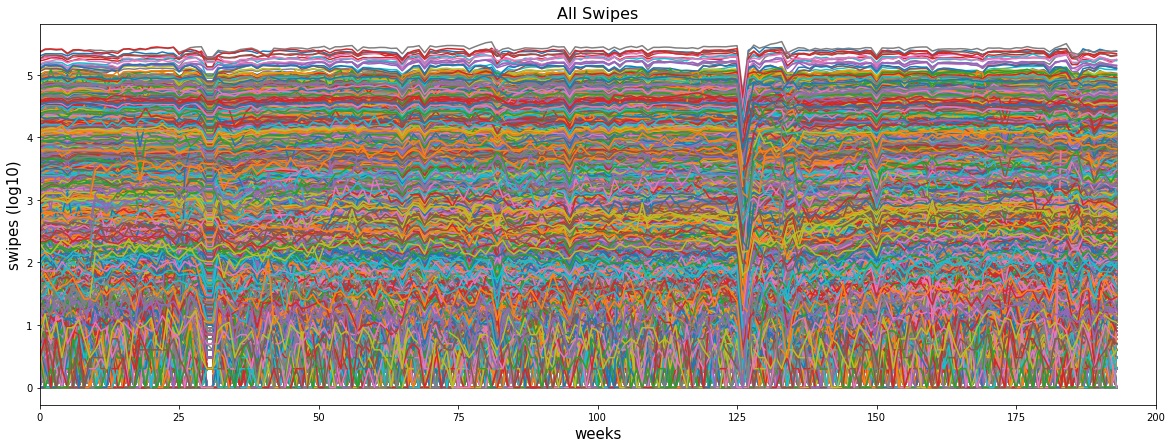

In [6]:
pl.figure(figsize=(20,7))
for i in np.arange(len(mta)):
    for j in np.arange(len(mta[i])):
        pl.plot(np.log10(mta[i][j]))
plt.title("All Swipes", fontsize=16)
plt.xlabel("weeks", fontsize=15)
plt.ylabel("swipes (log10)", fontsize=15)
plt.xlim(0, 200)
plt.show()

#### Figure 1: time series for all ride types and all stations in semi-log space. There is a downhill at week 125.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [7]:
mtaTotalstation=np.nansum(mta,axis=1)
print(mtaTotalstation.shape)

(600, 194)


In [8]:
mtaTotaltypes=np.nansum(mta,axis=0)
print(mtaTotaltypes.shape)

(23, 194)


In [9]:
mtaWeeks=np.nansum(mtaTotalstation,axis=0)
print(mtaWeeks.shape)

(194,)


In [10]:
data = pd.DataFrame({'mtaRides': mtaWeeks.T}, index=mtaDate)
data.head()

,mtaRides
2010-05-23,26720267.0
2010-05-30,29265971.0
2010-06-06,29601189.0
2010-06-13,29387592.0
2010-06-20,29185768.0


In [11]:
mtaDate

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [12]:
tsigma=[np.mean(data['mtaRides']) + 3 * np.std(data['mtaRides']), 
              np.mean(data['mtaRides']) - 3 * np.std(data['mtaRides'])]
tsigma

[38733231.13623668, 20829468.606031362]

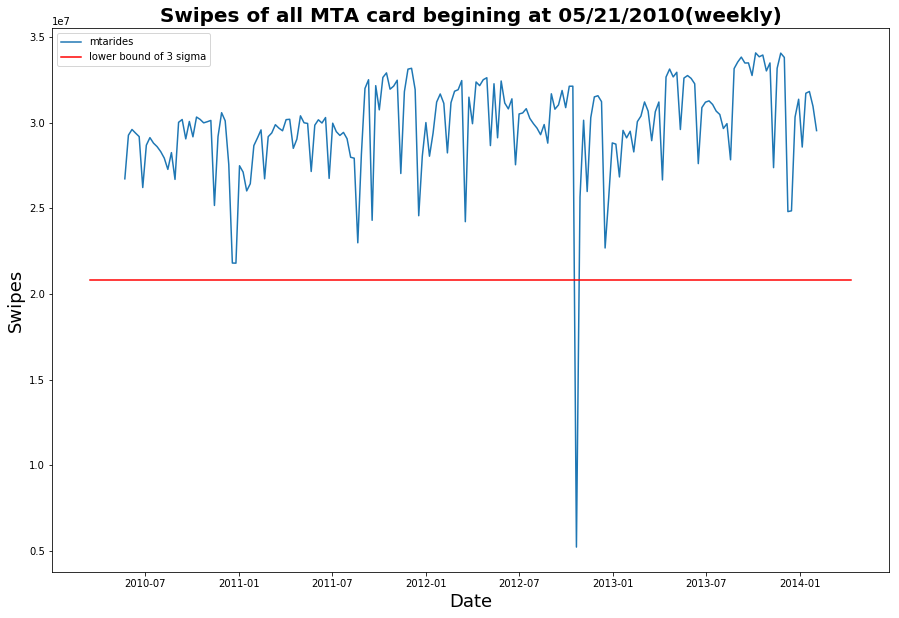

In [13]:
pl.figure(figsize=(15,10))
pl.plot(mtaDate, mtaWeeks, label='mtarides')
pl.plot([plt.xlim()[0], plt.xlim()[1]],[tsigma[1], tsigma[1]], color='r', label='lower bound of 3 sigma')
pl.xlabel('Date', fontsize = 18)
pl.ylabel('Swipes', fontsize = 18)
pl.title('Swipes of all MTA card begining at 05/21/2010(weekly)', fontsize = 20, weight='bold')
pl.legend()
pl.show();

#### Figure 2: Swipes of MTA card from 05/21/2010. There is a significance drop between 2012-08 and 2013-02 which is way lower than the lower bound of 3 sigma.

In [14]:
print(mtaDate[mtaWeeks==mtaWeeks.min()][0])
print(mtaWeeks.min())

2012-10-21 00:00:00
5218686.0


**Conclusion: The minimum ride is 5218686 at the week began at 2012-10-21 00:00:00. And the reason of this significance drop might be the occurance of Hurricane Sandy according to google.**

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [15]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

In [16]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [17]:
mtaTotaltypes.shape

(23, 194)

In [18]:
type=pd.DataFrame(mtaTotaltypes, index=ridetype, columns=mtaDate)
type=type.T
type.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-23,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
2010-05-30,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2010-06-06,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
2010-06-13,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
2010-06-20,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


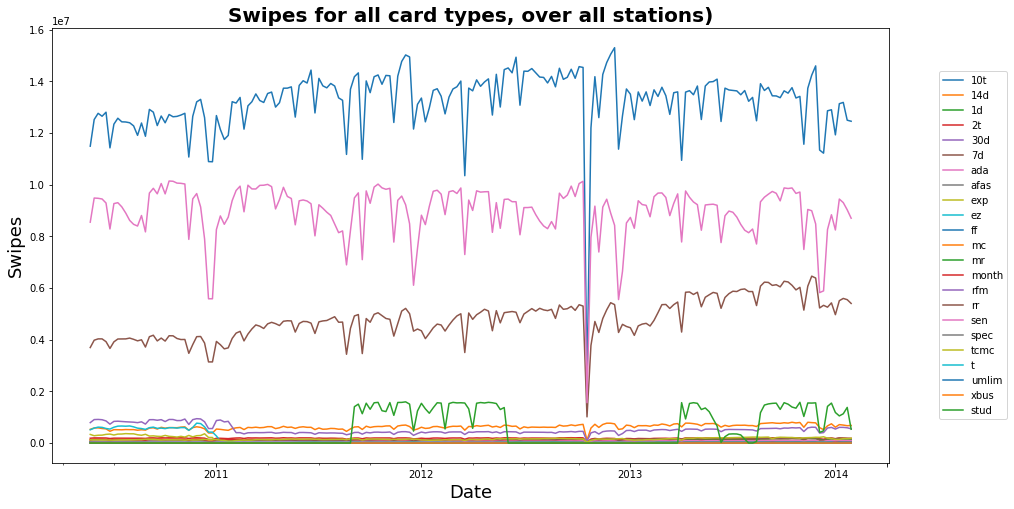

In [19]:
type.plot(figsize(15,8))
pl.xlabel('Date', fontsize = 18)
pl.ylabel('Swipes', fontsize = 18)
pl.title('Swipes for all card types, over all stations)', fontsize = 20, weight='bold')
pl.legend(loc='center',bbox_to_anchor=(1.1,0.5))
pl.show();

#### Figure 3: Swipes for 23 different card type, over all stations.  10t has the most swipe.

In [20]:
type.keys()

Index(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez', 'ff',
       'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't', 'umlim',
       'xbus', 'stud'],
      dtype='object')

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


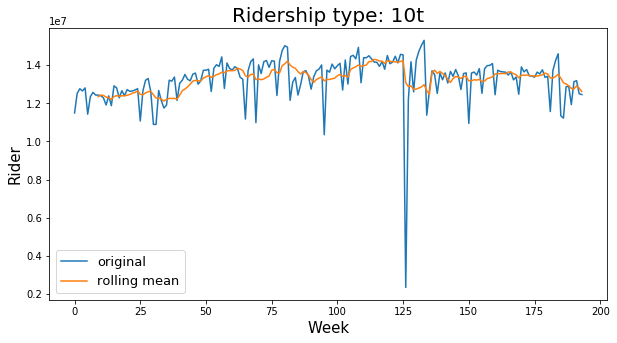

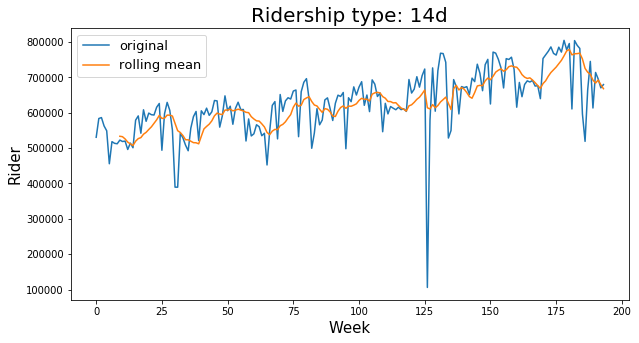

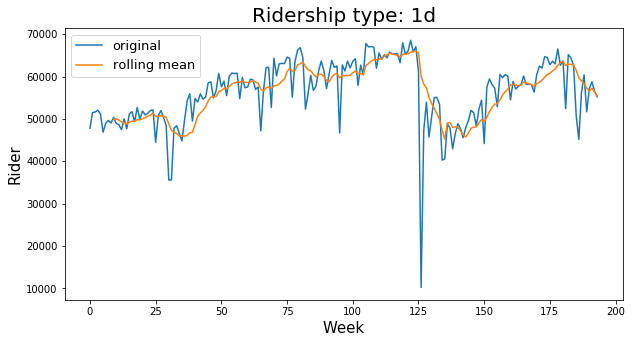

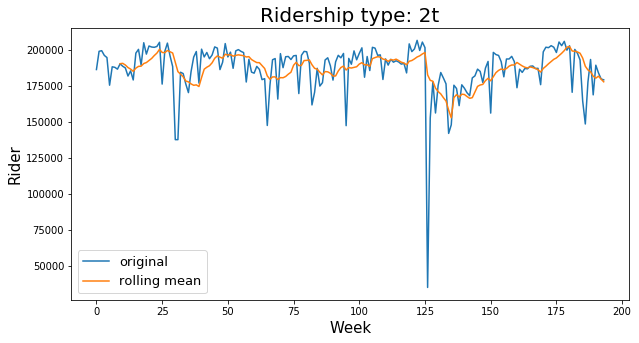

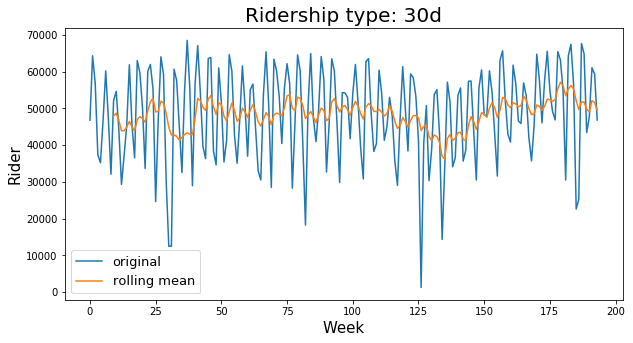

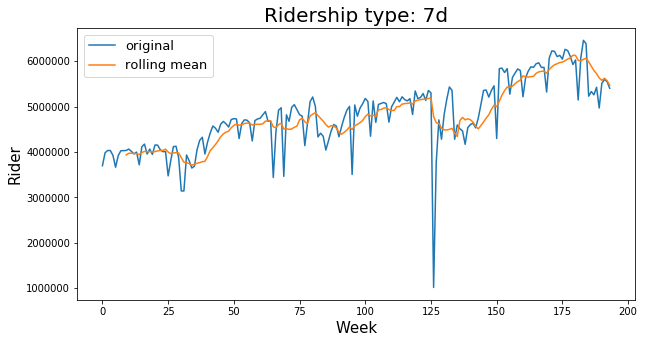

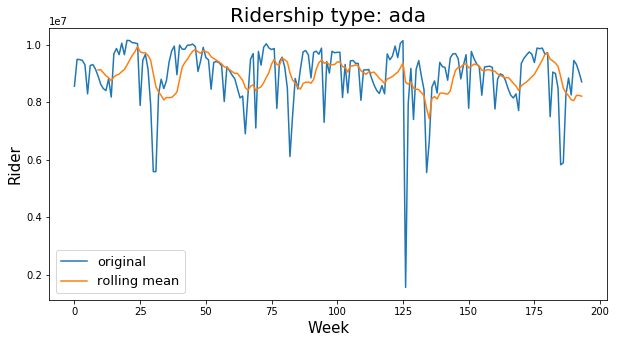

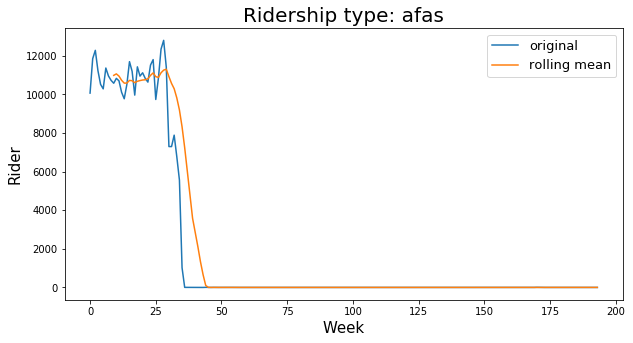

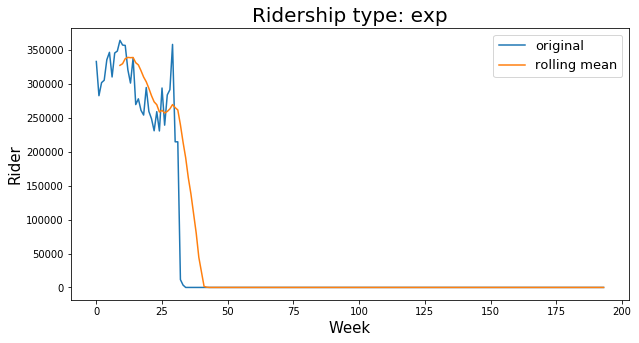

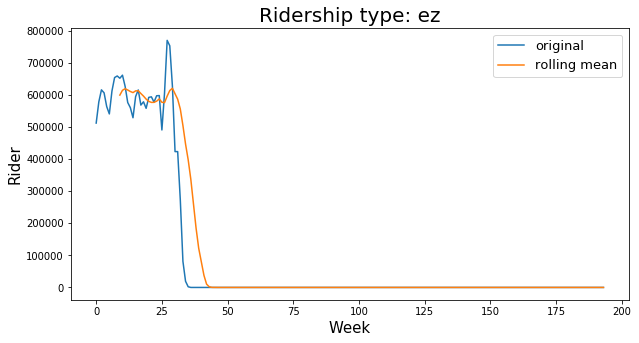

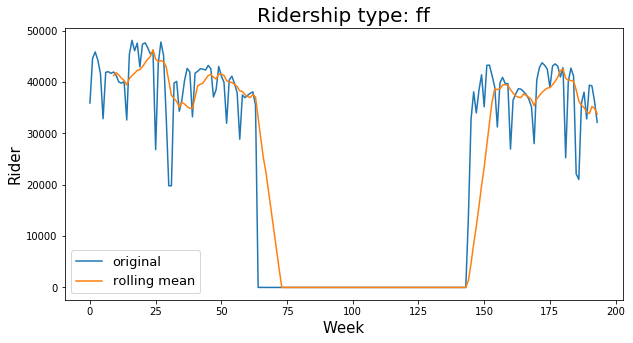

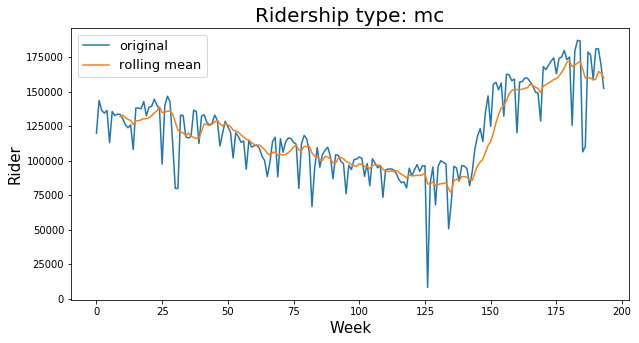

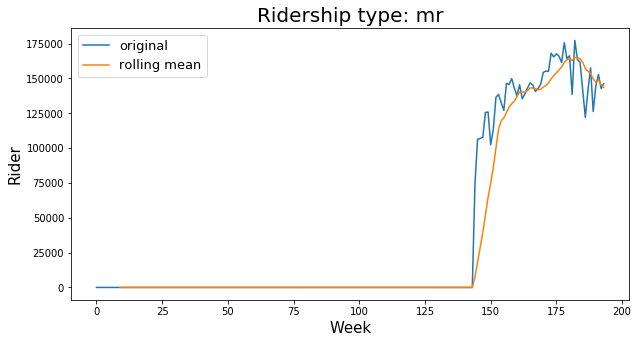

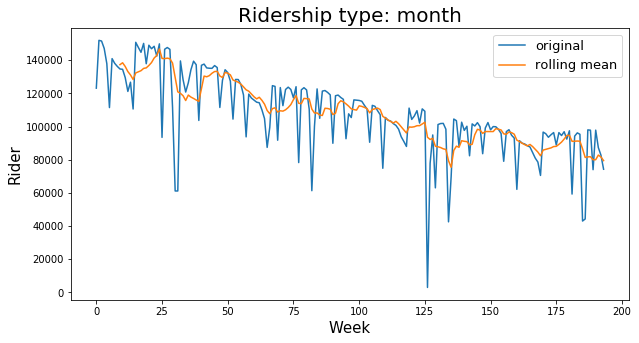

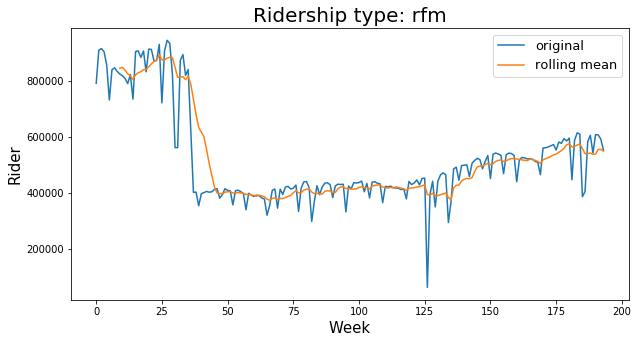

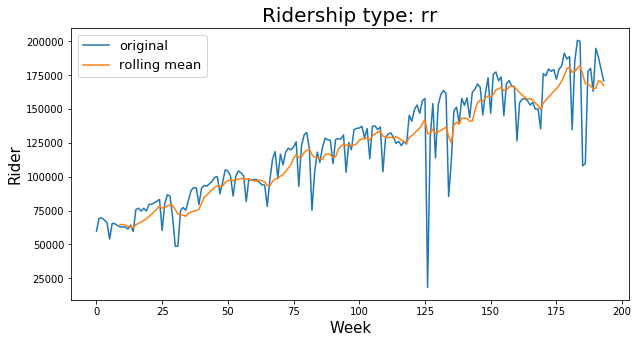

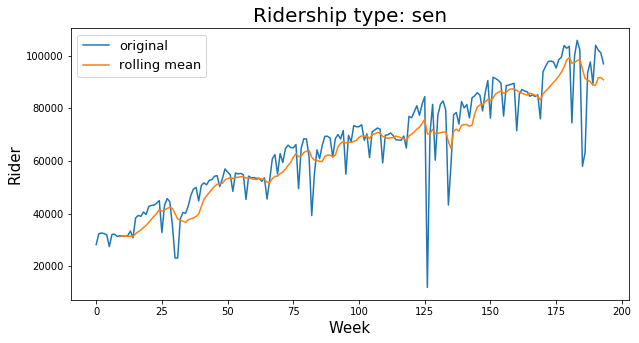

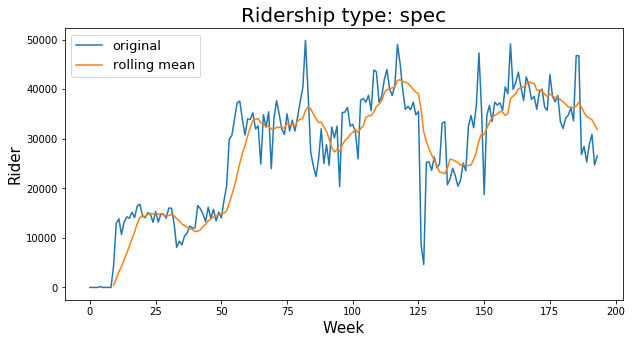

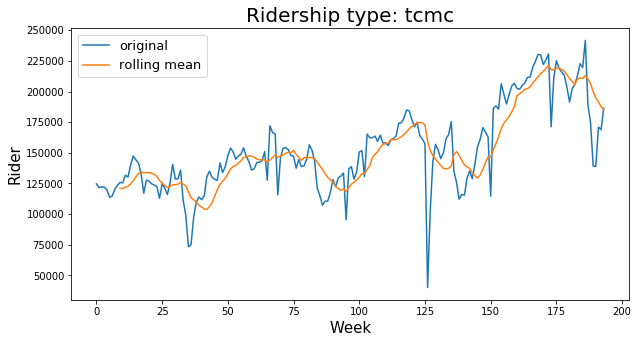

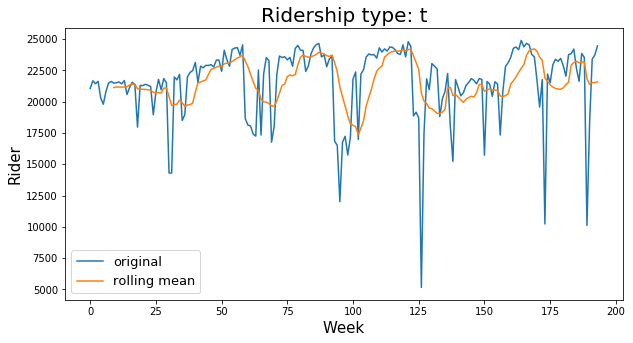

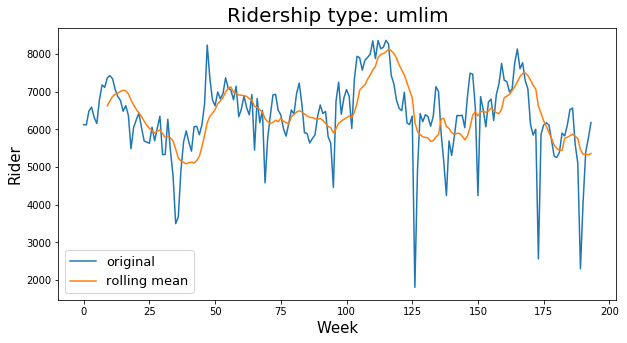

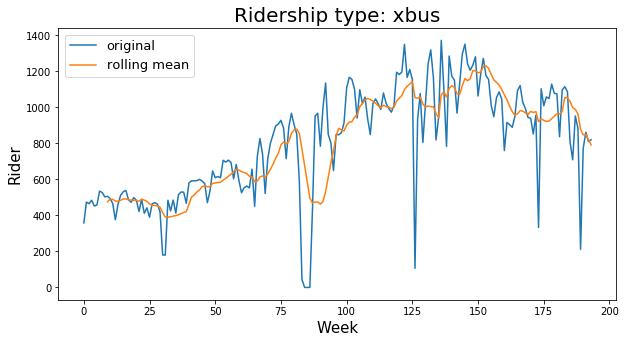

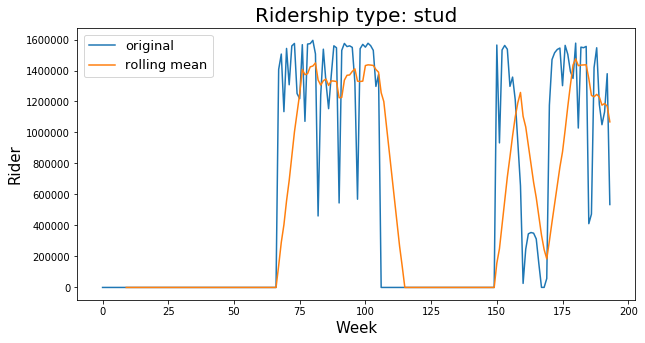

In [21]:
#fig = pl.figure(figsize=(20,100))
ratio=[]
for i in type.keys():
    fig=pl.figure(figsize=(10,5))
    rmean=type[i].rolling(window=10).mean()
    
    pl.plot(np.arange(len(type[i])), type[i], label='original')
    pl.plot(np.arange(len(type[i])), rmean, label='rolling mean')
    
    ratio.append((type[i].rolling(window=10).mean()).dropna().head(10).sum()/(type[i].rolling(window=10).mean()).dropna().tail(10).sum())
    
    pl.title("Ridership type: {}".format(i), fontsize=20)
    pl.ylabel("Rider", fontsize=15)
    pl.xlabel("Week", fontsize=15)
    pl.legend(fontsize=13)

#### Figure 4: rolling mean for 23 different card type by week

**Comment: From the figures above, ridership types: 14 days, 7 days, mail and ride, rail road and senior citizen has steadily increasing trend in popularity. While ridership types: ADA farecard access system, express, easy pay and monthly has steadily decreasing trend in popularity.The reason might be these type of card were out of use in the early years. And the ratio shown below also indicates the same conclusion I concluded about the graphs. **

In [22]:
riderratio=pd.DataFrame({"ratio":ratio}, index=ridetype, )
riderratio

,ratio
10t,0.952452
14d,0.740123
1d,0.846901
2t,1.017463
30d,0.893979
7d,0.693391
ada,1.067421
afas,4823.780269
exp,94866.755747
ez,511771.302521


# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

You can use the sklearn train_test_split() function to create your training and test dataset. 

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

and use sklearn confusion_matrix to see the errors

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [23]:
label = np.concatenate([np.array(range(23)) for i in range(600)])[mta.reshape(600*23, 194).std(1) > 0]
label.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(7660,)

In [24]:
label = label[~np.isnan(label)]
label.shape

(7660,)

In [25]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7])

In [26]:
stationsmeans = np.nanmean(mtaTotalstation,axis=1)
stationsmeans.shape

(600,)

In [27]:
stationsstd = np.nanstd(mtaTotalstation,axis=1)
stationsstd.shape

(600,)

In [28]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([  2,   2,   2, ..., 550, 550, 550])

In [29]:
tots = mta.reshape(600*23,194)
tots = tots[mta.reshape(600*23, 194).std(1) > 0]
tots.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(7660, 194)

In [30]:
normed_time_series = []
for i in range(tots.shape[0]):
    normed_time_series.append((tots[i] - stationsmeans[stationid[i]]) / stationsstd[stationid[i]])
normed_time_series=np.array(normed_time_series)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
normed_time_series_mean = np.nanmean(normed_time_series,axis=1)
normed_time_series_mean.shape

(7660,)

In [32]:
normed_time_series_std = np.nanstd(normed_time_series,axis=1)
normed_time_series_std.shape

/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1315: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


(7660,)

In [33]:
tsmean = np.mean(tots, axis=1)
tsmean.shape

(7660,)

In [34]:
tsstdev = np.std(tots,axis=1)
tsstdev.shape

(7660,)

Text(0,0.5,'standardized number of rides')

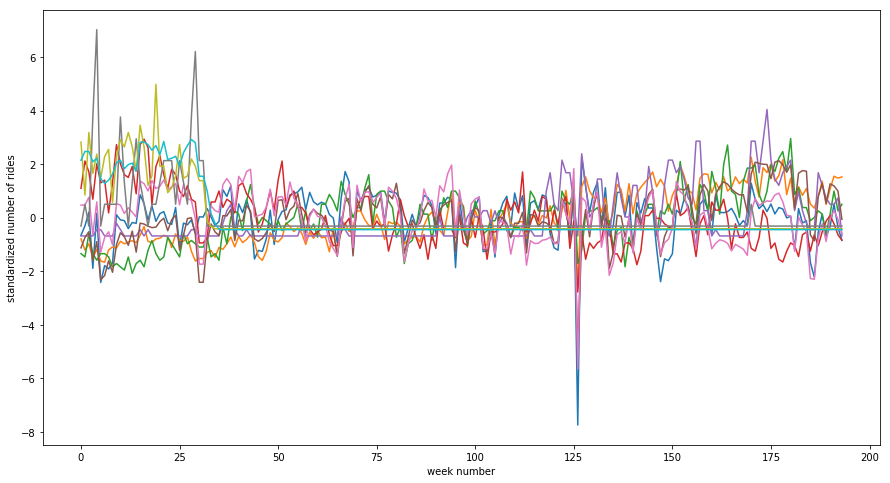

In [35]:
standardizedts = []
for i in range(tots.shape[0]):
    standardizedts.append((tots[i]-tsmean[i])/tsstdev[i])
standardizedts = np.array(standardizedts)
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

**Figure 5: The first 10 standardized swipes. The figure indicates that the data are randomly spread around at 0. There is significance drop at after week 125, which might due to the Hurricane Sandy.** 

In [36]:
allfits = []
for i in range(len(standardizedts)):
    smols = sm.OLS(standardizedts[i], sm.add_constant(np.array(range(1, 195)))).fit()
    allfits.append(smols)
[a.params[0] for a in allfits[:10]]

[-0.0095141428240503,
 -1.4698038513631968,
 -1.0801459983889143,
 1.078238027640132,
 -1.0339872015345257,
 -0.8803986803063728,
 0.5778840613724837,
 0.754636438173562,
 1.05547323323655,
 1.115014885482757]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              tsmean/normed_time_series_mean, tsstdev/normed_time_series_std]).T, 
    label, test_size=0.33, random_state=42)

In [38]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

In [39]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(135, 72, 0, 0)

In [40]:
X_test[~np.isfinite(X_test)] = 0
X_train[~np.isfinite(X_train)] = 0

In [41]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [42]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

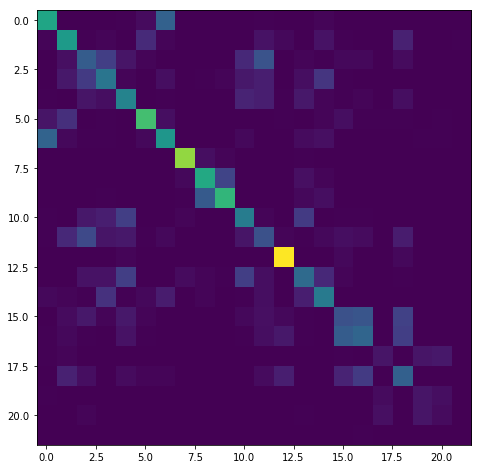

In [43]:
y_pred = clf.predict(X_test)
imshow(confusion_matrix(y_test, y_pred))

**Figure 6: Confusion matrix of the classfication. The brighter grid indicate correct prediction. So we can see from this figure that there is a diagonal predicted well from type 0(10t) to type 12(mr), after type 12(mr) the prediction model does not performed well.**

In [44]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.56      0.61      0.59       135
        14d       0.50      0.58      0.54       133
         1d       0.29      0.28      0.28       148
         2t       0.39      0.37      0.38       147
        30d       0.40      0.51      0.45       124
         7d       0.74      0.69      0.71       144
        ada       0.50      0.52      0.51       142
       afas       0.92      0.94      0.93       126
        exp       0.63      0.68      0.65       125
         ez       0.73      0.65      0.69       143
         ff       0.42      0.43      0.43       137
         mc       0.27      0.25      0.26       138
         mr       0.82      0.95      0.88       149
      month       0.41      0.34      0.37       146
        rfm       0.46      0.49      0.47       119
         rr       0.31      0.25      0.28       138
        sen       0.39      0.32      0.35       142
       spec       0.42      0.28      0.33   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))


**Conclusion:**
- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
- The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.
- The support is the number of samples of the true response that lie in that class.
- The last line is the weighted average of the above four features.
- We can from the table above, the accuracy continuing decreases after type mr.

In [45]:
clf.feature_importances_

array([0.26078125, 0.25100992, 0.34131985, 0.14688898])

**Conclusion: Higher value indicates higher importance this feature perform in the model. So in this case the most important feature is 3rd feature, which is the mean of all time series for that station divided by the mean of time series.**

## Build a model that uses as input features each time stamp (194 features) :


In [46]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(tots, label, test_size=0.33, random_state=42, shuffle=True)

In [47]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
y_pred = clf.predict(X_test)

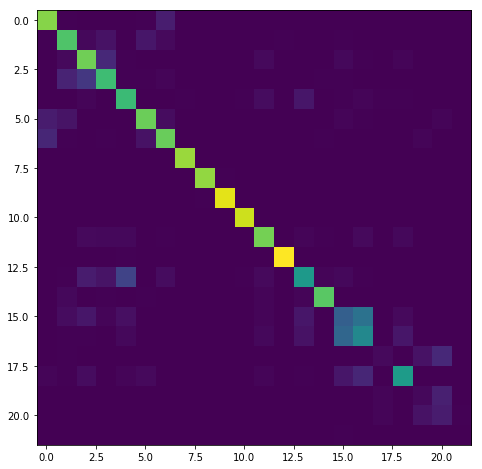

In [49]:
imshow(confusion_matrix(y_test, y_pred))

**Figure 7: Confusion matrix of the classfication in all 194 features. The brighter grid indicate correct prediction. So we can see from this figure that there is a diagonal predicted well from type 0(10t) to type 12(mr), after type 12(mr) the prediction model does not performed well.**

In [50]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.80      0.90      0.85       135
        14d       0.72      0.80      0.76       133
         1d       0.66      0.78      0.72       148
         2t       0.72      0.69      0.71       147
        30d       0.68      0.81      0.74       124
         7d       0.83      0.80      0.82       144
        ada       0.80      0.80      0.80       142
       afas       0.99      1.00      1.00       126
        exp       0.99      0.99      0.99       125
         ez       0.99      0.99      0.99       143
         ff       0.99      1.00      0.99       137
         mc       0.84      0.85      0.84       138
         mr       0.99      0.99      0.99       149
      month       0.73      0.55      0.62       146
        rfm       0.96      0.92      0.94       119
         rr       0.39      0.33      0.36       138
        sen       0.46      0.49      0.47       142
       spec       0.44      0.14      0.21   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))


**Conclusion: the weighted average of four features are all larger than the previous model, which means this model has classifies better than the previous one. But the accuracy falls after type mr, which previous model has this same issue as well.**

In [51]:
feature = clf.feature_importances_
feature

array([0.00991405, 0.00646534, 0.01346004, 0.01263033, 0.0077913 ,
       0.010243  , 0.00523829, 0.00693261, 0.006598  , 0.01130319,
       0.01076934, 0.00240526, 0.01027392, 0.00655527, 0.00992625,
       0.00886508, 0.00752507, 0.00934497, 0.00426219, 0.0105316 ,
       0.00287324, 0.01205997, 0.00356605, 0.00525724, 0.01170242,
       0.01035312, 0.01071119, 0.00602917, 0.00642434, 0.00986253,
       0.01134238, 0.0146841 , 0.01758148, 0.01355151, 0.0154727 ,
       0.00906851, 0.00487419, 0.00849507, 0.00300868, 0.00317624,
       0.01471641, 0.00332895, 0.00313076, 0.00807495, 0.00257086,
       0.00234155, 0.00409102, 0.00682795, 0.00272076, 0.00195248,
       0.00686146, 0.00231823, 0.00172029, 0.00791931, 0.00173865,
       0.01101479, 0.00340297, 0.00759599, 0.00256391, 0.00681605,
       0.00668715, 0.00613003, 0.00267574, 0.003249  , 0.00258295,
       0.00286384, 0.00675286, 0.00169654, 0.00312779, 0.00368444,
       0.00195211, 0.00192327, 0.00173937, 0.00633233, 0.00252

In [52]:
max = np.amax(feature)

In [53]:
np.where(feature == max)

(array([32]),)

**Conclusion: The 33th feature is the most important feature for prediction among the total of 194 features.**